In [1]:
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [3]:
imsize = 224

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

In [5]:
content_img = image_loader("images/landscape.jpg")
style_img = image_loader("images/monet.jpg")

In [6]:
unloader = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
    transforms.ToPILImage()])

In [7]:
def tensor2image(tensor):
    image = tensor.clone() 
    image = image.squeeze(0)  
    image = unloader(image)
    return image

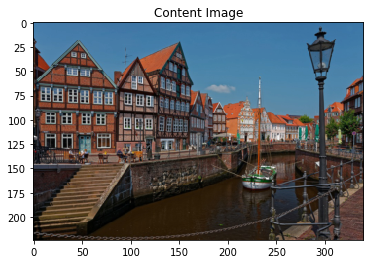

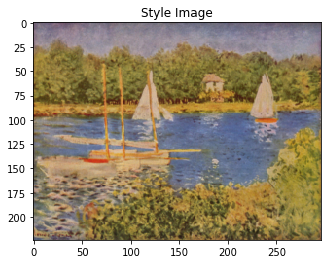

In [8]:
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()

plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [9]:
model = models.vgg19(pretrained=True).features

for param in model.parameters():
    param.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [10]:
relevant_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

In [11]:
def features_extractor(x, model, layers):
        
    features = {}
    for index, layer in model._modules.items():
        if index in layers:
            x = layer(x)
            features[layers[index]] = x
            
    return features

In [12]:
content_features = features_extractor(content_img, model, relevant_layers)
style_features = features_extractor(style_img, model, relevant_layers)

In [13]:
style_grams = {}
for i in style_features:
    layer = style_features[i]
    _, d1, d2, d3 = layer.shape
    features = layer.view(d1, d2 * d3)
    gram = torch.mm(features, features.t())
    style_grams[i] = gram

In [14]:
target_img = content_img.clone().requires_grad_(True)

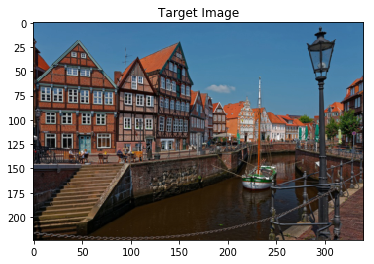

In [15]:
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title("Target Image")
plt.show()

In [16]:
style_weights = {'conv1_1': 1., 'conv2_1': 0.8, 'conv3_1': 0.6, 'conv4_1': 0.4, 'conv5_1': 0.2}

In [17]:
alpha = 1
beta = 1e6

In [18]:
print_statement = 5000
optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 30000

Total loss:  8.039841254430552e+21


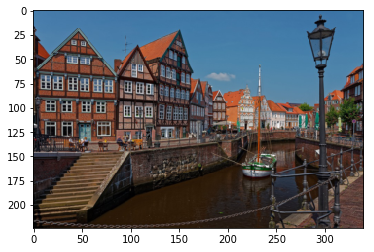

Total loss:  2.8579775065572246e+19


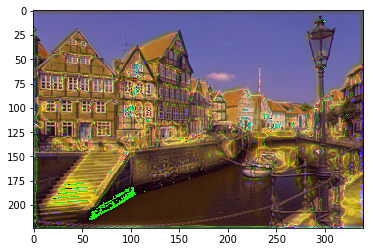

Total loss:  1.4172662275957064e+18


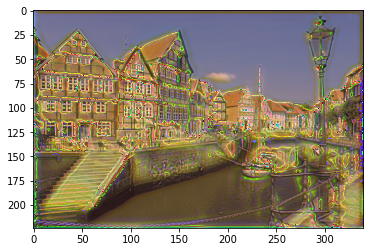

Total loss:  4.525991181670154e+17


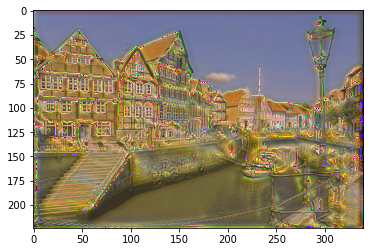

Total loss:  4.234197975527588e+17


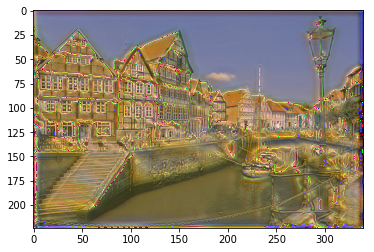

Total loss:  4.166746373137367e+17


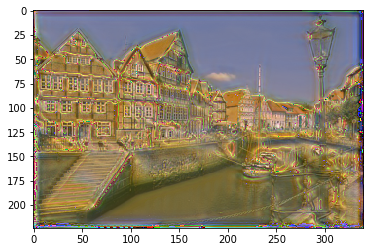

Total loss:  4.133825277014835e+17


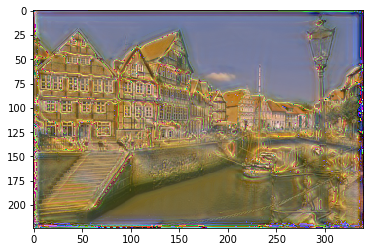

In [19]:
for i in range(1, iterations+1):
    
    target_features = features_extractor(target_img, model, relevant_layers)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_losses = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        _, d1, d2, d3 = target_feature.shape
        
        target_reshaped = target_feature.view(d1, d2 * d3)
        target_gram = torch.mm(target_reshaped, target_reshaped.t())
        style_gram = style_grams[layer]
                
        style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_losses += style_loss / (d1 * d2 * d3)
        
    total_loss = alpha * content_loss + beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  i % print_statement == 0 or i == 1:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor2image(target_img))
        plt.show()

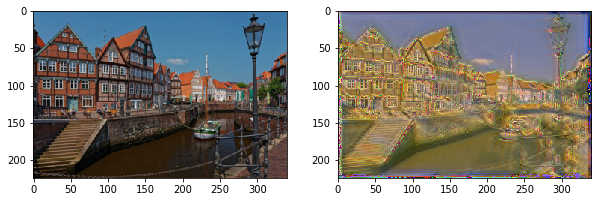

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
plt.show()